In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path

#os.environ["MODIN_ENGINE"] = "ray"

#import modin.pandas as pd
import pandas as pd

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from horizonplot import horizonplot
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

In [2]:
meta_data_samples = pd.read_table("../data/meta_data_samples.txt", sep = " ")

In [3]:
#Opening the tables generated in heterozygosity_windows
het_counts_path = "../steps/het_counts_windows_{}.txt"
callability_percentage_path = "../steps/callability_windows_{}.txt"
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']
het_list = []
call_list = []
for chrom in chromosomes:
    df = pd.read_table(het_counts_path.format(chrom), sep = " ")
    het_list.append(df)
    c_df = pd.read_table(callability_percentage_path.format(chrom), sep = " ")
    call_list.append(c_df)
het_df = pd.concat(het_list, axis=0)
call_df = pd.concat(call_list, axis=0)
#There are some columns with NaN, replacing those with 0
het_df["het"] = het_df["het"].fillna(0)
#Renaming columns to make horizonplot work
original_names = het_df.copy()
het_df.rename(columns = {"window": "start", "chr": "chrom", "PGDP_ID": "pop"}, inplace=True)

#Check lengths for each chromosome/ID combination, and cutting off final parts if incongruent.
trimmed_het = []
trimmed_call = []
for chrom in chromosomes:
    chrom_df = original_names.loc[original_names.chr == chrom].copy()
    callability_df = call_df.loc[call_df.chr == chrom].copy()
    for i, row in meta_data_samples.iterrows():
        chrom_i = chrom_df.loc[chrom_df.PGDP_ID == row.PGDP_ID]
        call_i = callability_df.loc[callability_df.PGDP_ID == row.PGDP_ID]
        chrom_i["sex"] = row.Sex[:]
        chrom_i["species"] = row.Species[:]
        call_i["sex"] = row.Sex[:]
        call_i["species"] = row.Species[:]
        if len(chrom_i) > len(call_i):
            trimmed_het.append(chrom_i.iloc[:len(call_i)])
            trimmed_call.append(call_i)
        elif len(chrom_i) < len(call_i):
            trimmed_call.append(call_i.iloc[:len(chrom_i)])
            trimmed_het.append(chrom_i)
    print(chrom)
het_df_trimmed = pd.concat(trimmed_het, axis=0)
call_df_trimmed = pd.concat(trimmed_call, axis=0)
call_df_trimmed.loc[call_df_trimmed.coverage == 0, "coverage"] = 1

het_df_trimmed["het_c"] = het_df_trimmed["het"].values/call_df_trimmed["coverage"].values
het_df_trimmed.to_csv("../steps/het_df_trimmed.txt", sep = " ", index=False)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [4]:
meta_data_samples

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
0,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
1,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
2,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2
3,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3
4,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4
...,...,...,...,...,...,...,...,...,...,...,...,...
155,212,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155
156,213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156
157,214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157
158,215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158


In [5]:
het_df_trimmed

,chr,window,PGDP_ID,het,sex,species,het_c
0,chr1,0,PD_0199,337.0,F,anubis,419.535150
1,chr1,1,PD_0199,168.0,F,anubis,183.014510
2,chr1,2,PD_0199,90.0,F,anubis,127.695800
3,chr1,3,PD_0199,379.0,F,anubis,1179.619658
4,chr1,4,PD_0199,127.0,F,anubis,216.498184
...,...,...,...,...,...,...,...
245430,chrX,1524,PD_0793,268.0,M,kindae,271.923861
245431,chrX,1525,PD_0793,1002.0,M,kindae,1643.619901
245432,chrX,1526,PD_0793,302.0,M,kindae,665.667431
245433,chrX,1527,PD_0793,874.0,M,kindae,917.672011


In [6]:
#Getting the mean values for each chromosome per ID, in long format.
df_list = []
for chrom in chromosomes:
    het_df_trimmed_chrom = het_df_trimmed.loc[het_df_trimmed.chr == chrom]
    temp_df = pd.DataFrame()
    m_l = []
    id_l = []
    for i, row in meta_data_samples.iterrows():
        ID = row.PGDP_ID
        id_df = het_df_trimmed_chrom.loc[het_df_trimmed_chrom.PGDP_ID == ID]
        m_l.append(id_df["het_c"].mean()/100000) #Dividing by window size
        id_l.append(ID)
    temp_df["mean_het"] = m_l
    temp_df["PGDP_ID"] = id_l
    temp_df["chr"] = chrom
    df_list.append(temp_df)
    print(chrom)
chr_means = pd.concat(df_list, axis=0)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [7]:
#Getting the mean values for each chromosome per ID, in wide format.
df_list = []
for i, row in meta_data_samples.iterrows():
    ID = row.PGDP_ID
    id_df = het_df_trimmed.loc[het_df_trimmed.PGDP_ID == ID]  
    temp_df = pd.DataFrame()
    total = []
    for chrom in chromosomes:
        het_df_trimmed_chrom = id_df.loc[id_df.chr == chrom]
        temp_df[chrom] = [het_df_trimmed_chrom["het_c"].mean()/100000]
        if chrom != ["chrX", "chr7"]:
            total.extend(het_df_trimmed_chrom["het_c"].values)
    temp_df["autosomes"] = sum(total)/(len(total)*100000)
    temp_df["PGDP_ID"] = ID
    df_list.append(temp_df)
    print(ID)
chr_means_wide = pd.concat(df_list, axis=0, ignore_index=True) #assembling the dataframe
chr_means_wide = pd.concat([chr_means_wide, meta_data_samples], axis=1) #Adding meta data
chr_means_wide["X/chr7"] = chr_means_wide["chrX"]/chr_means_wide["chr7"] #Ratio of heterozygosity

PD_0199
PD_0200
PD_0201
PD_0202
PD_0203
PD_0204
PD_0205
PD_0206
PD_0207
PD_0208
PD_0209
PD_0210
PD_0211
PD_0212
PD_0213
PD_0214
PD_0215
PD_0216
PD_0217
PD_0218
PD_0219
PD_0220
PD_0221
PD_0222
PD_0223
PD_0224
PD_0225
PD_0226
PD_0227
PD_0228
PD_0229
PD_0230
PD_0231
PD_0232
PD_0233
PD_0234
PD_0235
PD_0236
PD_0237
PD_0238
PD_0239
PD_0240
PD_0241
PD_0242
PD_0243
PD_0244
PD_0390
PD_0391
PD_0392
PD_0393
PD_0394
PD_0395
PD_0396
PD_0397
PD_0398
PD_0399
PD_0400
PD_0401
PD_0692
PD_0693
PD_0694
PD_0695
PD_0696
PD_0697
PD_0698
PD_0699
PD_0700
PD_0701
PD_0702
PD_0703
PD_0704
PD_0705
PD_0706
PD_0707
PD_0708
PD_0709
PD_0710
PD_0711
PD_0712
PD_0713
PD_0714
PD_0715
PD_0716
PD_0717
PD_0718
PD_0719
PD_0720
PD_0721
PD_0722
PD_0723
PD_0724
PD_0725
PD_0726
PD_0727
PD_0728
PD_0729
PD_0730
PD_0731
PD_0732
PD_0733
PD_0734
PD_0735
PD_0736
PD_0737
PD_0738
PD_0739
PD_0740
PD_0741
PD_0742
PD_0743
PD_0744
PD_0745
PD_0746
PD_0747
PD_0748
PD_0749
PD_0750
PD_0751
PD_0752
PD_0753
PD_0754
PD_0755
PD_0756
PD_0757
PD_0758


In [8]:
chr_means_wide

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,X/chr7
0,0.001938,0.001384,0.002068,0.002060,0.001984,0.001724,0.002062,0.001674,0.001997,0.002184,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0,0.422217
1,0.001861,0.001803,0.001901,0.002033,0.002001,0.001883,0.002052,0.001757,0.001944,0.002110,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1,0.413903
2,0.001820,0.001744,0.002013,0.002146,0.001985,0.001922,0.001965,0.002089,0.002114,0.002154,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2,0.304087
3,0.001862,0.001806,0.001788,0.002102,0.002035,0.001841,0.002096,0.001889,0.002087,0.002032,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3,0.312013
4,0.001623,0.001749,0.002027,0.002056,0.001962,0.001914,0.002065,0.001865,0.002040,0.002097,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4,0.487914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.002680,0.002545,0.002999,0.002142,0.003028,0.001806,0.001625,0.003029,0.003011,0.002964,...,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155,0.772753
156,0.002728,0.002693,0.002682,0.003070,0.002915,0.002541,0.002703,0.002763,0.003039,0.002945,...,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156,0.464469
157,0.002575,0.002597,0.002987,0.002979,0.002154,0.002876,0.002777,0.002844,0.002980,0.002932,...,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157,0.476170
158,0.002782,0.002581,0.002951,0.002981,0.002978,0.002614,0.002857,0.002875,0.002354,0.002840,...,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158,0.496001


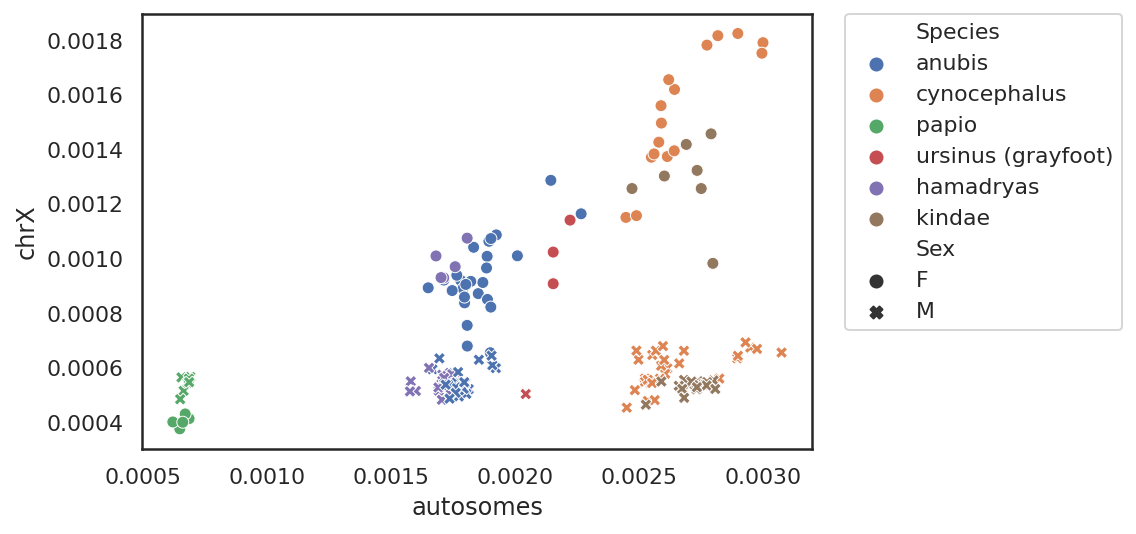

In [9]:
#Raw
sns.scatterplot(data = chr_means_wide, y="chrX", x="autosomes", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

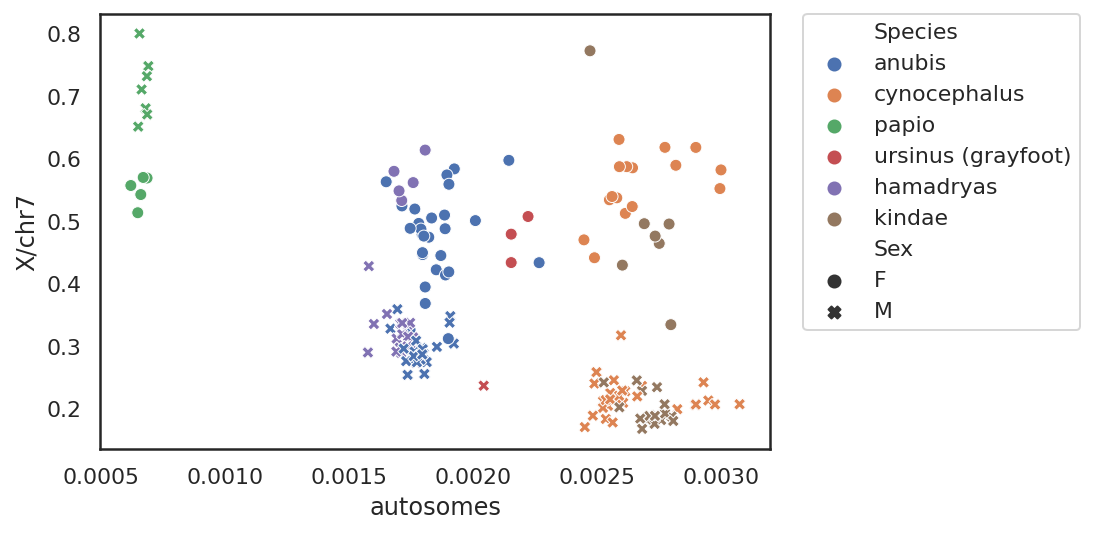

In [10]:
#Correcting for heterozzygosity on a chromosome
sns.scatterplot(data = chr_means_wide, y="X/chr7", x="autosomes", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

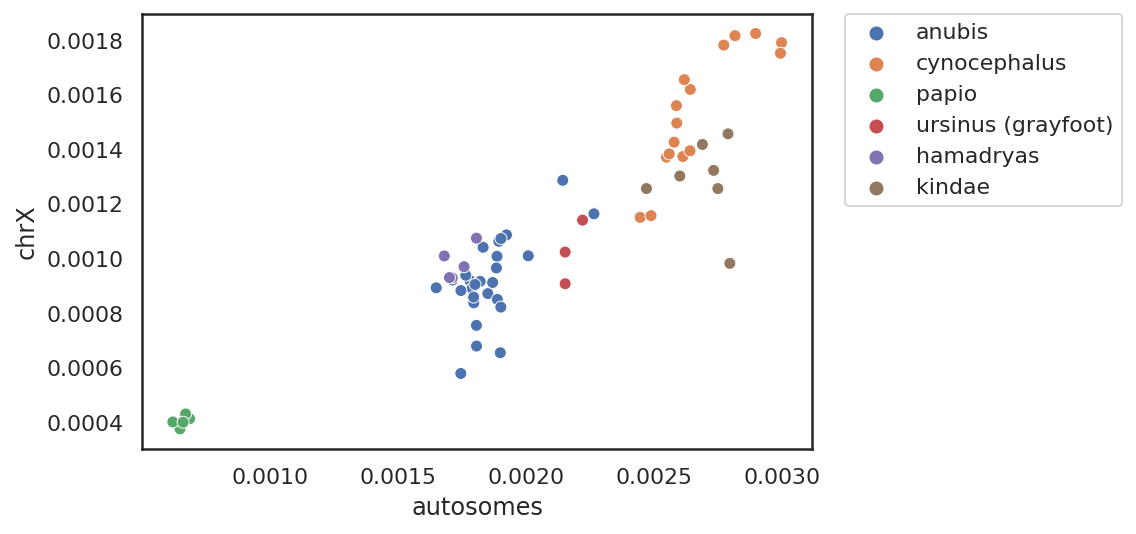

In [11]:
#Subsetting to only contain females
chr_means_wide_females = chr_means_wide.loc[chr_means_wide.Sex == "F"]
sns.scatterplot(data = chr_means_wide_females, y="chrX", x="autosomes", hue="Species")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

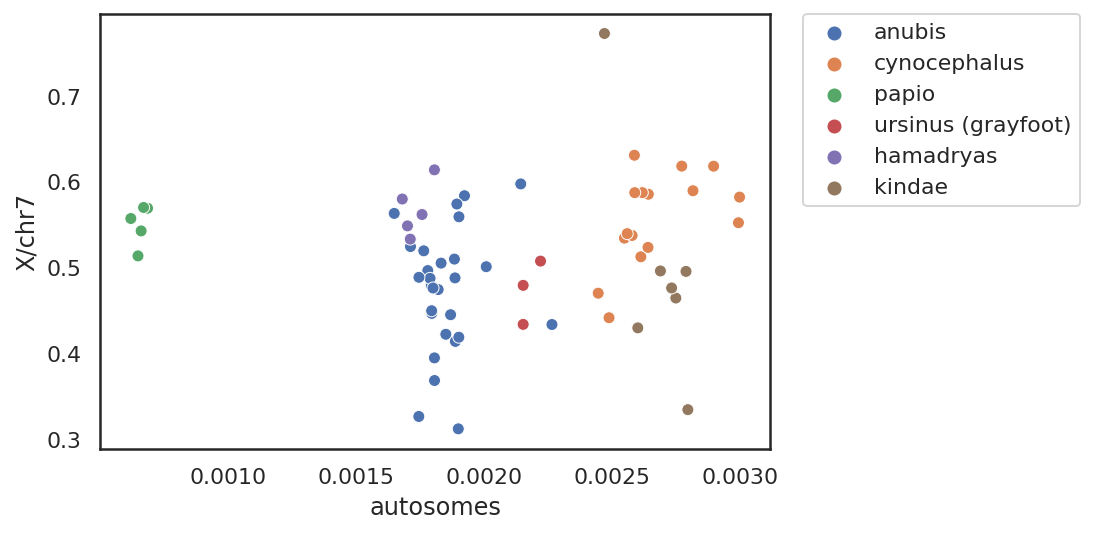

In [12]:
sns.scatterplot(data = chr_means_wide_females, y="X/chr7", x="autosomes", hue="Species")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='mean_het', ylabel='Count'>

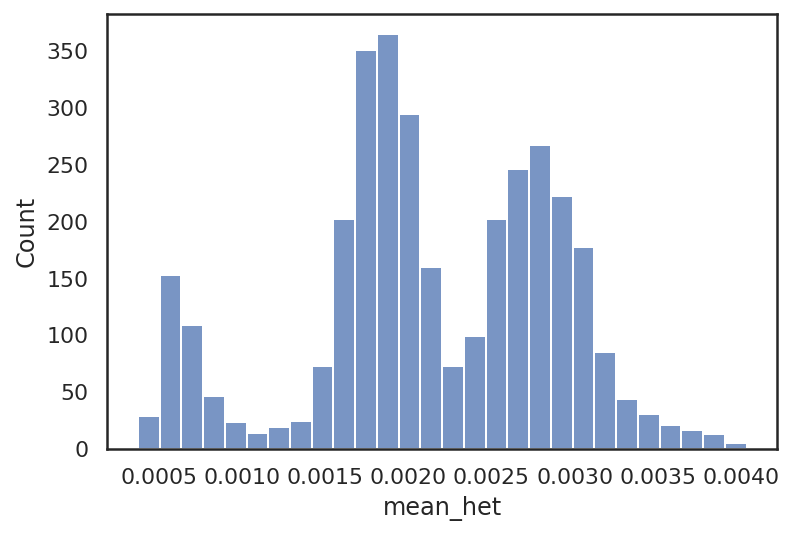

In [13]:
sns.histplot(data = chr_means, x="mean_het")

In [14]:
#Picking a specific species in the metadata, and then plotting the distribution on the X and chr7 on horizonplots
species_list = []
for s in meta_data_samples.Species.unique():
    species = meta_data_samples[meta_data_samples.Species == s].PGDP_ID.values
    s_df = het_df_trimmed.loc[het_df_trimmed.PGDP_ID.isin(species)]
    het_list = []
    window = []
    chr_list = []
    for chrom in chromosomes:
        chr_df = s_df.loc[s_df.chr == chrom]
        for i in range(max(chr_df["window"])):
            window.append(i)
            chr_list.append(chrom)
            mean_het = chr_df.loc[chr_df.window == i]["het_c"].mean()
            het_list.append(mean_het)
    d_s = {"window": window, "mean_het": het_list, "chr": chr_list}
    mean_df_species = pd.DataFrame(data = d_s)
    mean_df_species["species"] = s
    species_list.append(mean_df_species)
    print(s, species)
species_means = pd.concat(species_list, axis=0, ignore_index=True)

anubis ['PD_0199' 'PD_0200' 'PD_0201' 'PD_0202' 'PD_0203' 'PD_0204' 'PD_0205'
 'PD_0206' 'PD_0207' 'PD_0208' 'PD_0209' 'PD_0210' 'PD_0211' 'PD_0212'
 'PD_0218' 'PD_0219' 'PD_0220' 'PD_0221' 'PD_0222' 'PD_0238' 'PD_0239'
 'PD_0240' 'PD_0241' 'PD_0242' 'PD_0243' 'PD_0244' 'PD_0720' 'PD_0721'
 'PD_0722' 'PD_0723' 'PD_0724' 'PD_0725' 'PD_0726' 'PD_0727' 'PD_0728'
 'PD_0729' 'PD_0730' 'PD_0731' 'PD_0732' 'PD_0733' 'PD_0734' 'PD_0735'
 'PD_0736' 'PD_0737' 'PD_0738' 'PD_0739' 'PD_0740' 'PD_0741' 'PD_0742'
 'PD_0743' 'PD_0744']
cynocephalus ['PD_0213' 'PD_0214' 'PD_0215' 'PD_0216' 'PD_0217' 'PD_0223' 'PD_0224'
 'PD_0225' 'PD_0226' 'PD_0227' 'PD_0228' 'PD_0229' 'PD_0230' 'PD_0231'
 'PD_0232' 'PD_0233' 'PD_0234' 'PD_0235' 'PD_0236' 'PD_0237' 'PD_0745'
 'PD_0746' 'PD_0747' 'PD_0748' 'PD_0752' 'PD_0753' 'PD_0754' 'PD_0755'
 'PD_0756' 'PD_0757' 'PD_0761' 'PD_0762' 'PD_0763' 'PD_0764' 'PD_0765'
 'PD_0766' 'PD_0767' 'PD_0768' 'PD_0769' 'PD_0770' 'PD_0771' 'PD_0772'
 'PD_0773' 'PD_0774' 'PD_0775']
pap

In [15]:
species_means

,window,mean_het,chr,species
0,0,181.097149,chr1,anubis
1,1,218.699582,chr1,anubis
2,2,251.193779,chr1,anubis
3,3,1217.408294,chr1,anubis
4,4,400.248874,chr1,anubis
...,...,...,...,...
169933,1523,97.825633,chrX,kindae
169934,1524,290.419085,chrX,kindae
169935,1525,1689.058506,chrX,kindae
169936,1526,656.102737,chrX,kindae


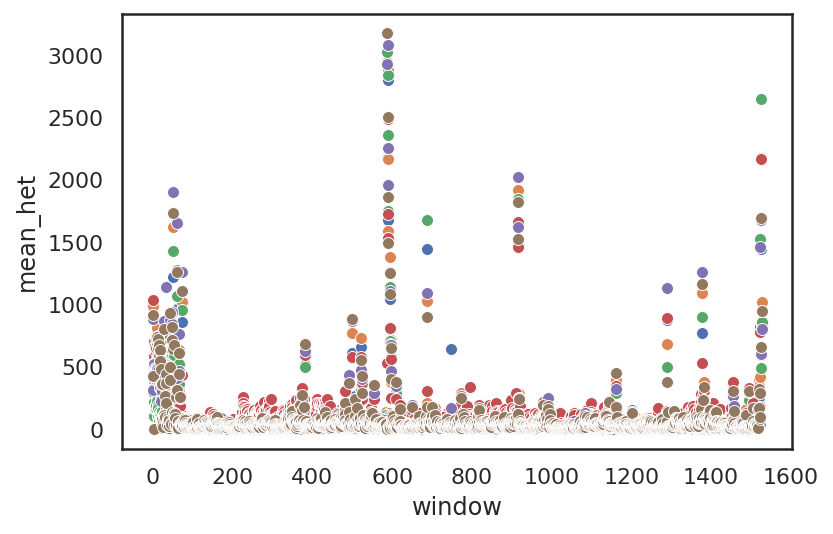

In [16]:
#This results in plotting everything over each other,
#but it does show that areas of increased heterozygosity is shared among species
#Horizonplot would be an improvement here
for s in meta_data_samples.Species.unique():
    species = species_means.loc[species_means.species == s]
    x_s = species.loc[species.chr == "chrX"]
    sns.scatterplot(data=x_s, x="window", y="mean_het")

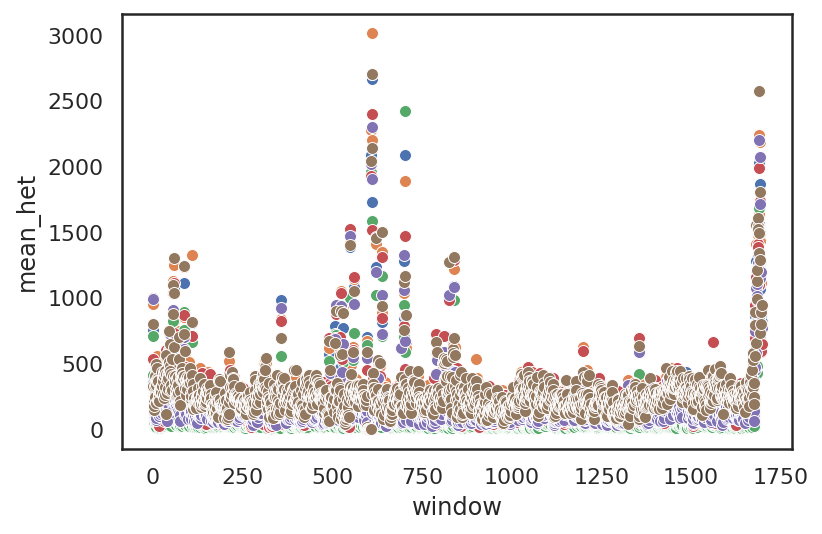

In [17]:
for s in meta_data_samples.Species.unique():
    species = species_means.loc[species_means.species == s]
    x_s = species.loc[species.chr == "chr7"]
    sns.scatterplot(data=x_s, x="window", y="mean_het")

In [18]:
x_species = species_means.loc[species_means.chr == "chrX"]
x_species.rename(columns = {"window": "start", "chr": "chrom", "species": "pop"}, inplace=True)
chr7_species = species_means.loc[species_means.chr == "chr7"]
chr7_species.rename(columns = {"window": "start", "chr": "chrom", "species": "pop"}, inplace=True)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


['anubis' 'cynocephalus' 'papio' 'ursinus (grayfoot)' 'hamadryas' 'kindae']


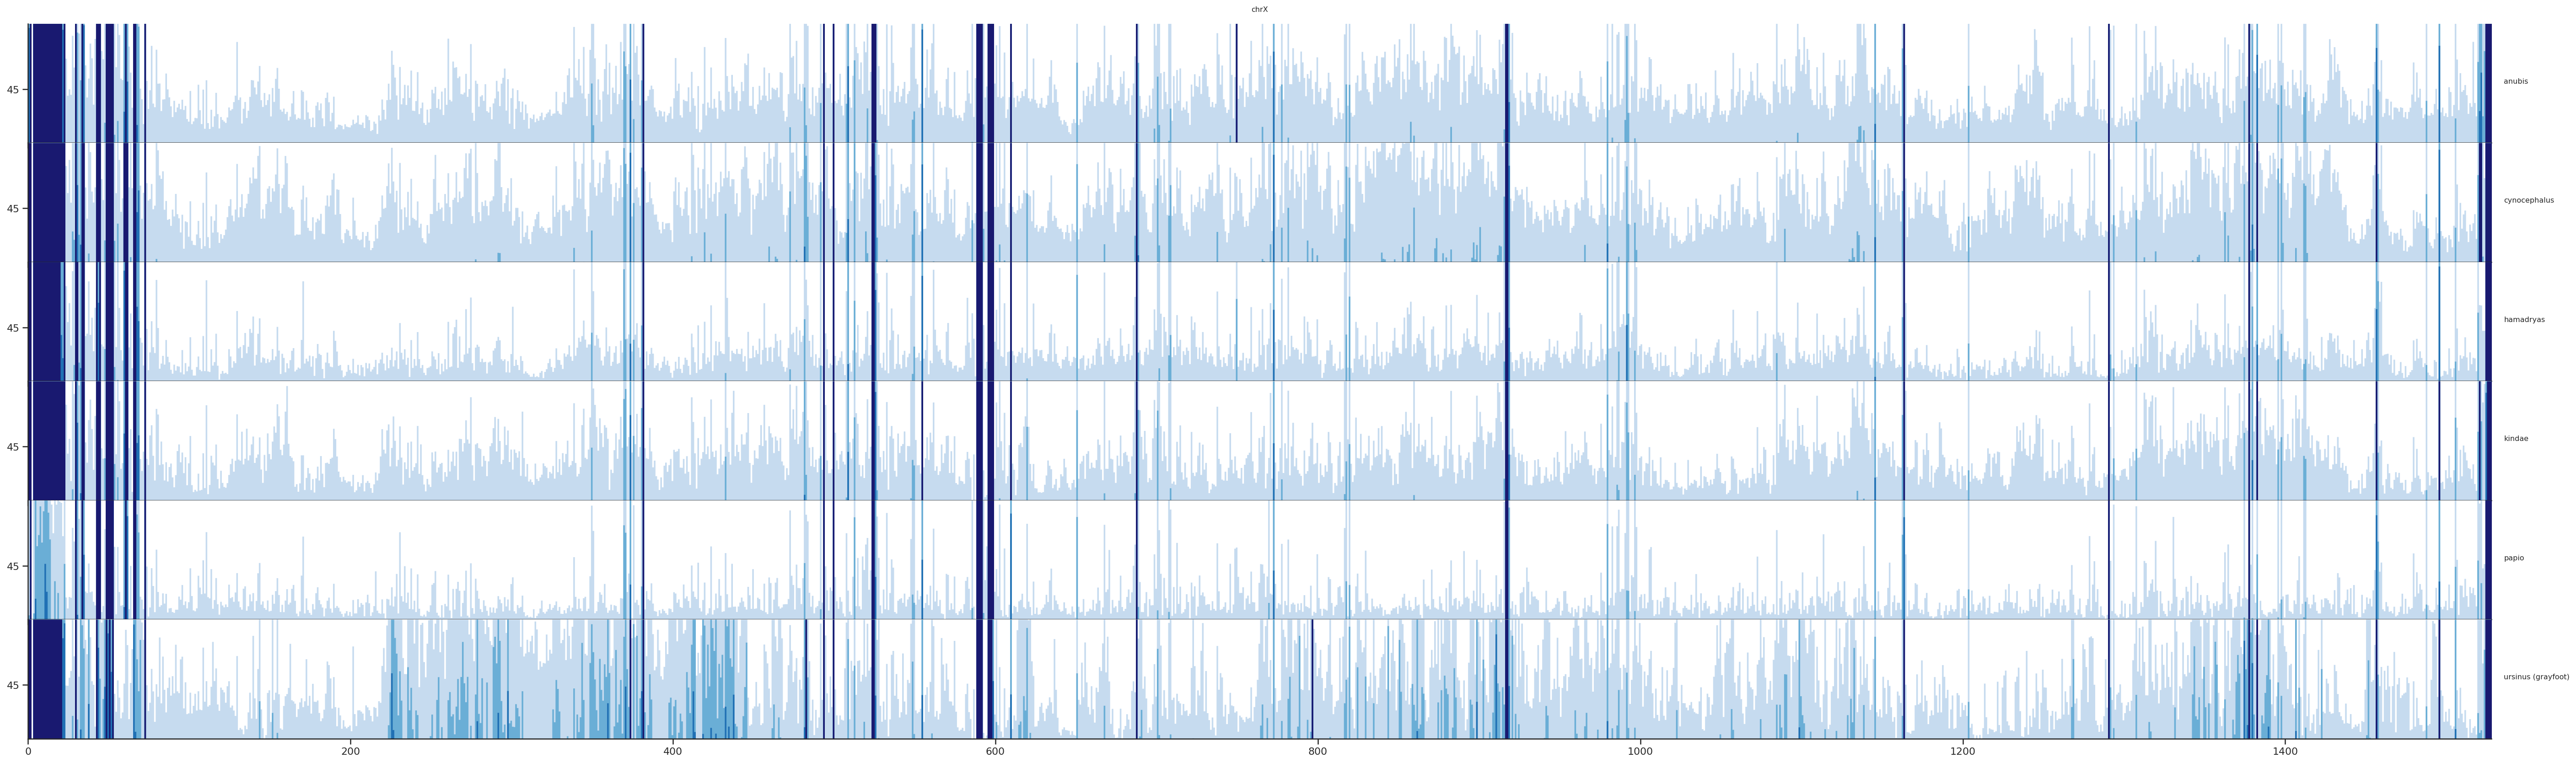

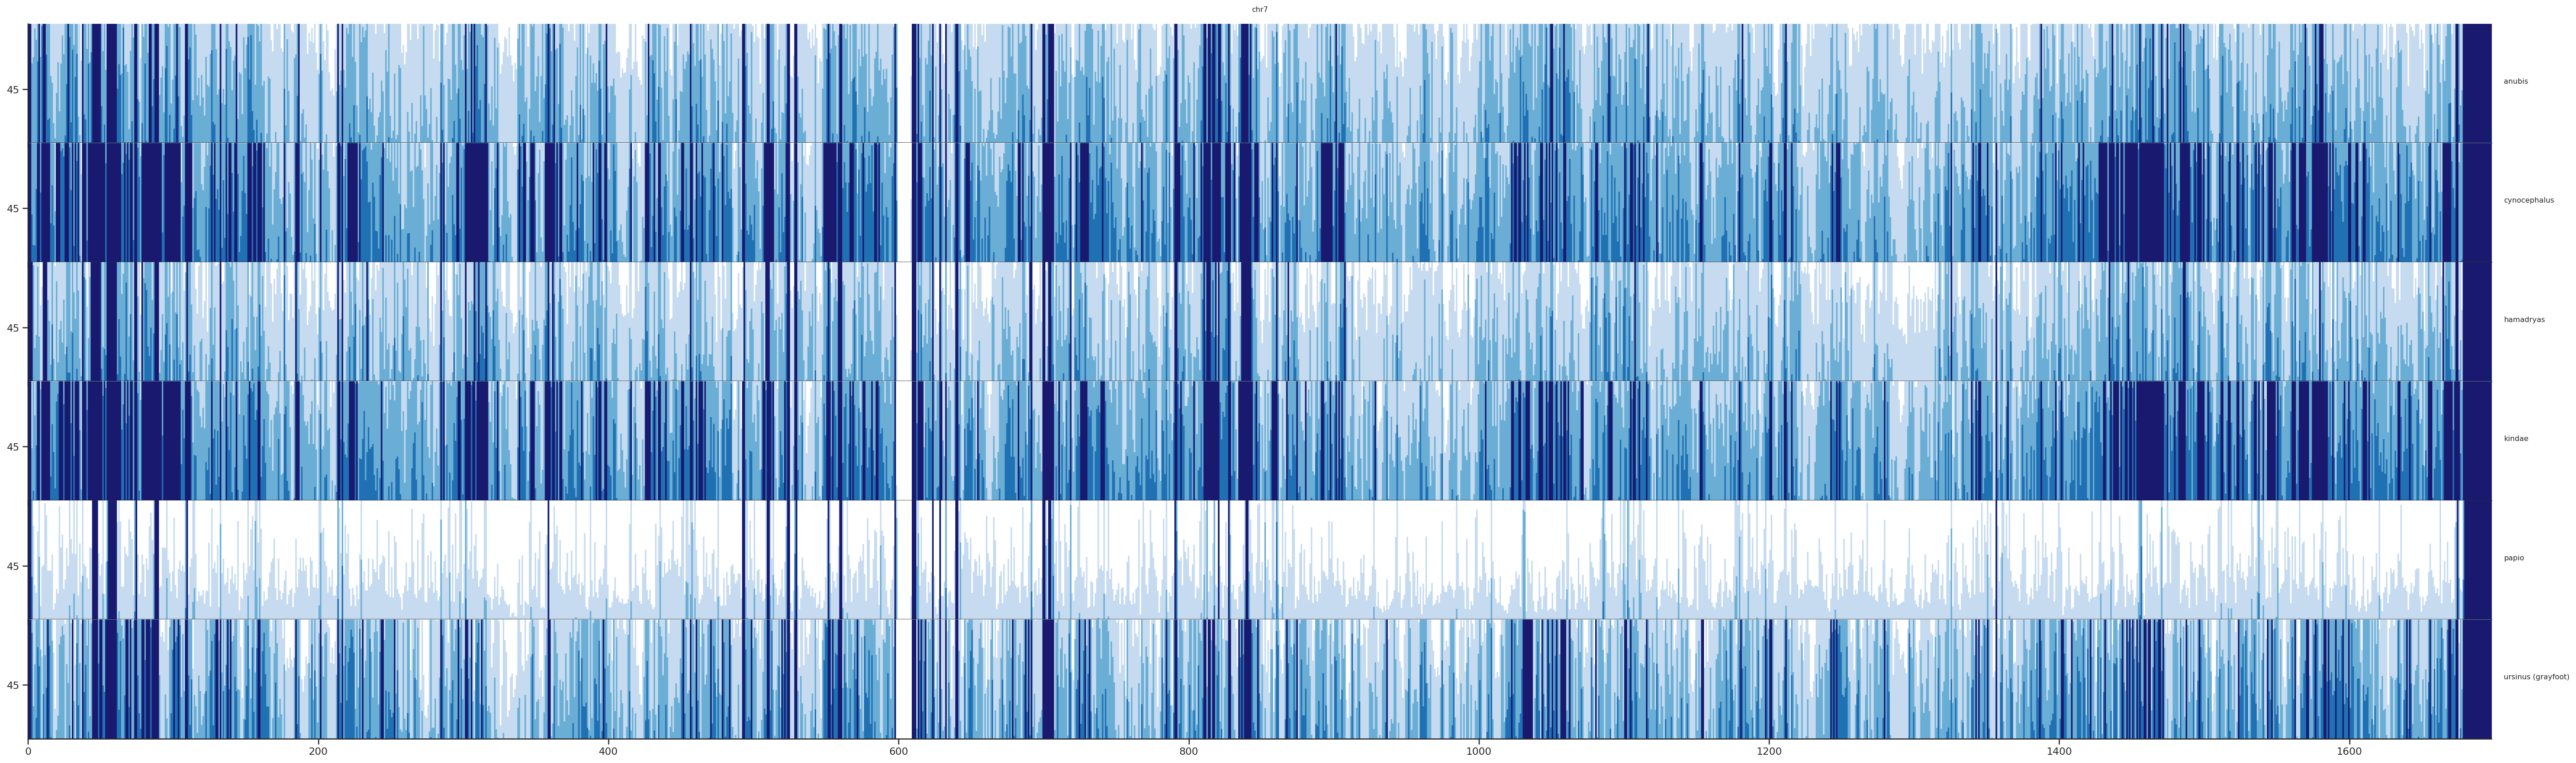

In [19]:
#Order of species in plot:
print(meta_data_samples.Species.unique())
fig = horizonplot(x_species,
                   'mean_het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 100)
fig = horizonplot(chr7_species,
                   'mean_het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 100)

In [20]:
##Redoing previous analysis, but only allowing females
#Picking a specific species in the metadata, and then plotting the distribution on the X and chr7 on horizonplots
species_list = []
for s in meta_data_samples.Species.unique():
    species = meta_data_samples[(meta_data_samples.Species == s) & (meta_data_samples.Sex == "F")].PGDP_ID.values
    s_df = het_df_trimmed.loc[het_df_trimmed.PGDP_ID.isin(species)]
    het_list = []
    window = []
    chr_list = []
    for chrom in chromosomes:
        chr_df = s_df.loc[s_df.chr == chrom]
        for i in range(max(chr_df["window"])):
            window.append(i)
            chr_list.append(chrom)
            mean_het = chr_df.loc[chr_df.window == i]["het_c"].mean()
            het_list.append(mean_het)
    d_s = {"window": window, "mean_het": het_list, "chr": chr_list}
    mean_df_species = pd.DataFrame(data = d_s)
    mean_df_species["species"] = s
    species_list.append(mean_df_species)
    print(s, species)
species_means = pd.concat(species_list, axis=0, ignore_index=True)

anubis ['PD_0199' 'PD_0200' 'PD_0202' 'PD_0203' 'PD_0205' 'PD_0206' 'PD_0208'
 'PD_0209' 'PD_0210' 'PD_0211' 'PD_0212' 'PD_0219' 'PD_0221' 'PD_0222'
 'PD_0238' 'PD_0239' 'PD_0240' 'PD_0241' 'PD_0243' 'PD_0244' 'PD_0721'
 'PD_0724' 'PD_0726' 'PD_0730' 'PD_0736' 'PD_0737' 'PD_0738' 'PD_0744']
cynocephalus ['PD_0213' 'PD_0214' 'PD_0216' 'PD_0224' 'PD_0225' 'PD_0226' 'PD_0232'
 'PD_0237' 'PD_0745' 'PD_0754' 'PD_0765' 'PD_0769' 'PD_0770' 'PD_0772'
 'PD_0773' 'PD_0774']
papio ['PD_0390' 'PD_0391' 'PD_0392' 'PD_0393' 'PD_0394']
ursinus (grayfoot) ['PD_0693' 'PD_0694' 'PD_0695']
hamadryas ['PD_0698' 'PD_0700' 'PD_0701' 'PD_0708' 'PD_0710']
kindae ['PD_0760' 'PD_0781' 'PD_0788' 'PD_0789' 'PD_0790' 'PD_0791' 'PD_0792']


In [21]:
x_species = species_means.loc[species_means.chr == "chrX"]
x_species.rename(columns = {"window": "start", "chr": "chrom", "species": "pop"}, inplace=True)
chr7_species = species_means.loc[species_means.chr == "chr7"]
chr7_species.rename(columns = {"window": "start", "chr": "chrom", "species": "pop"}, inplace=True)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


['anubis' 'cynocephalus' 'papio' 'ursinus (grayfoot)' 'hamadryas' 'kindae']


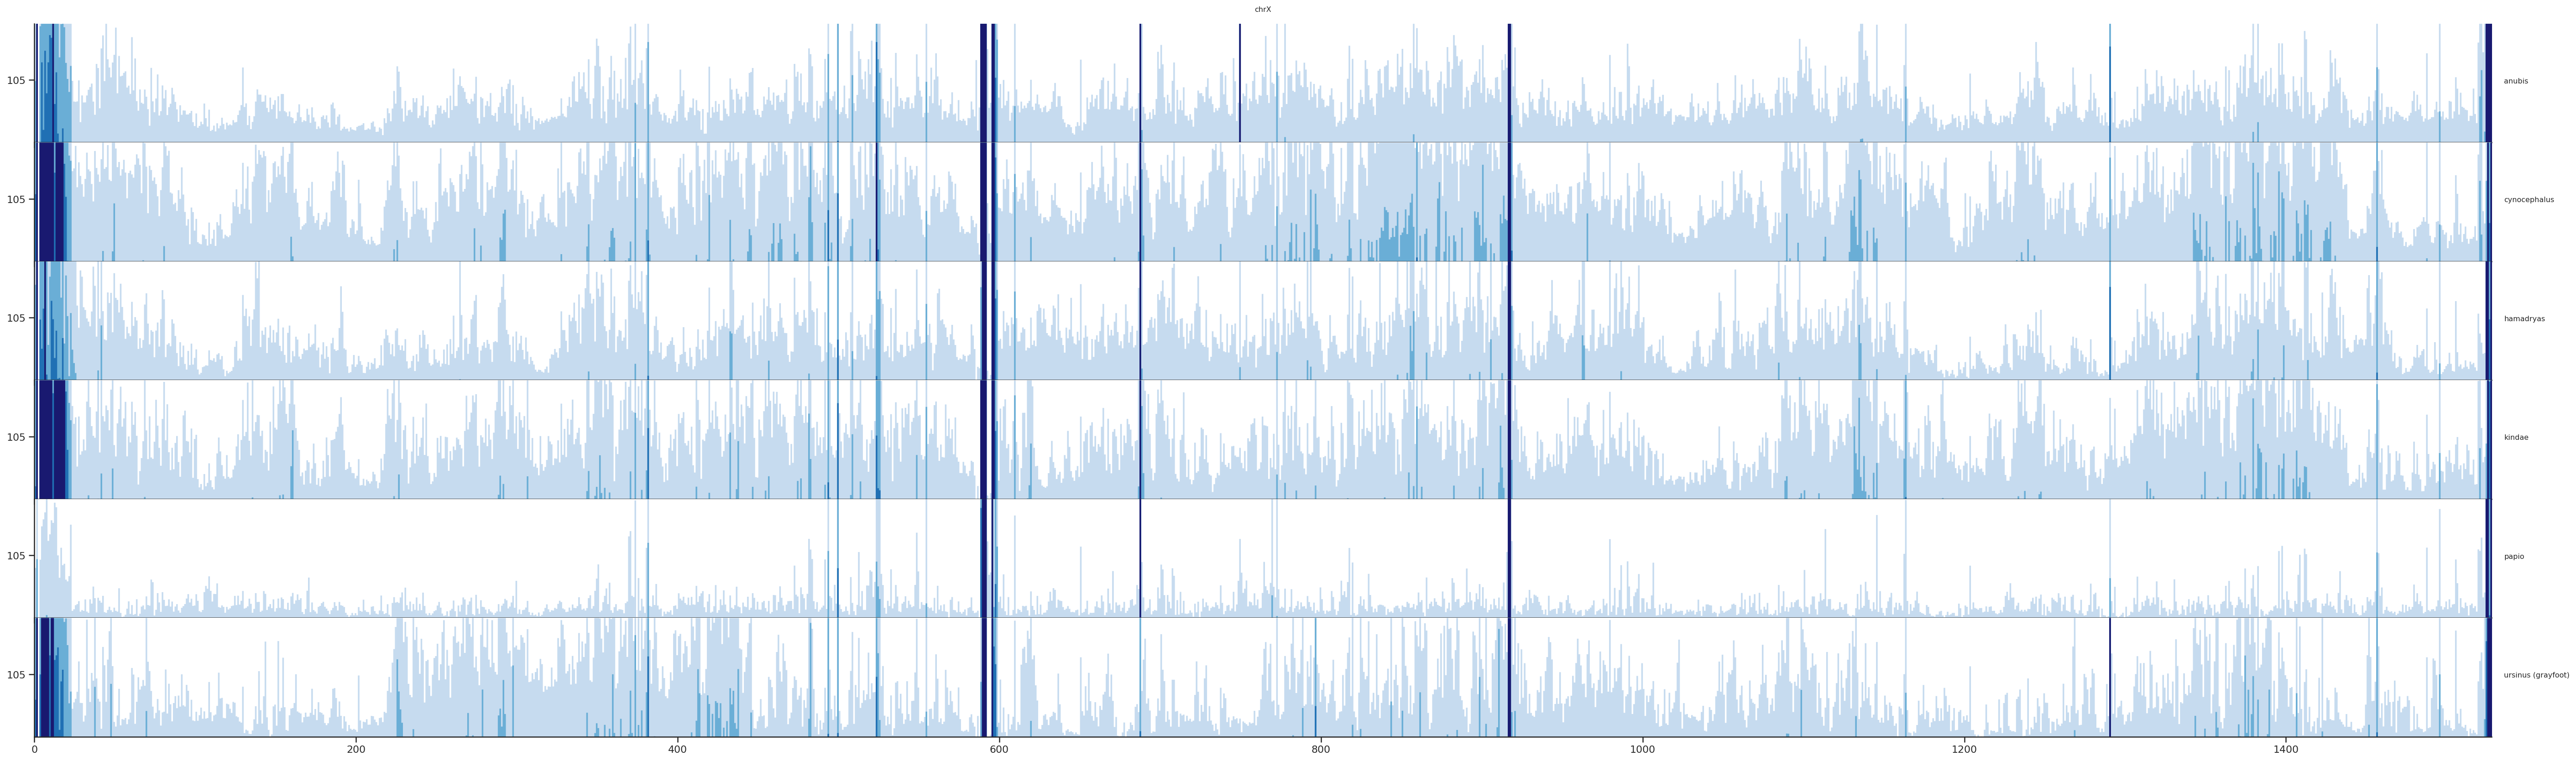

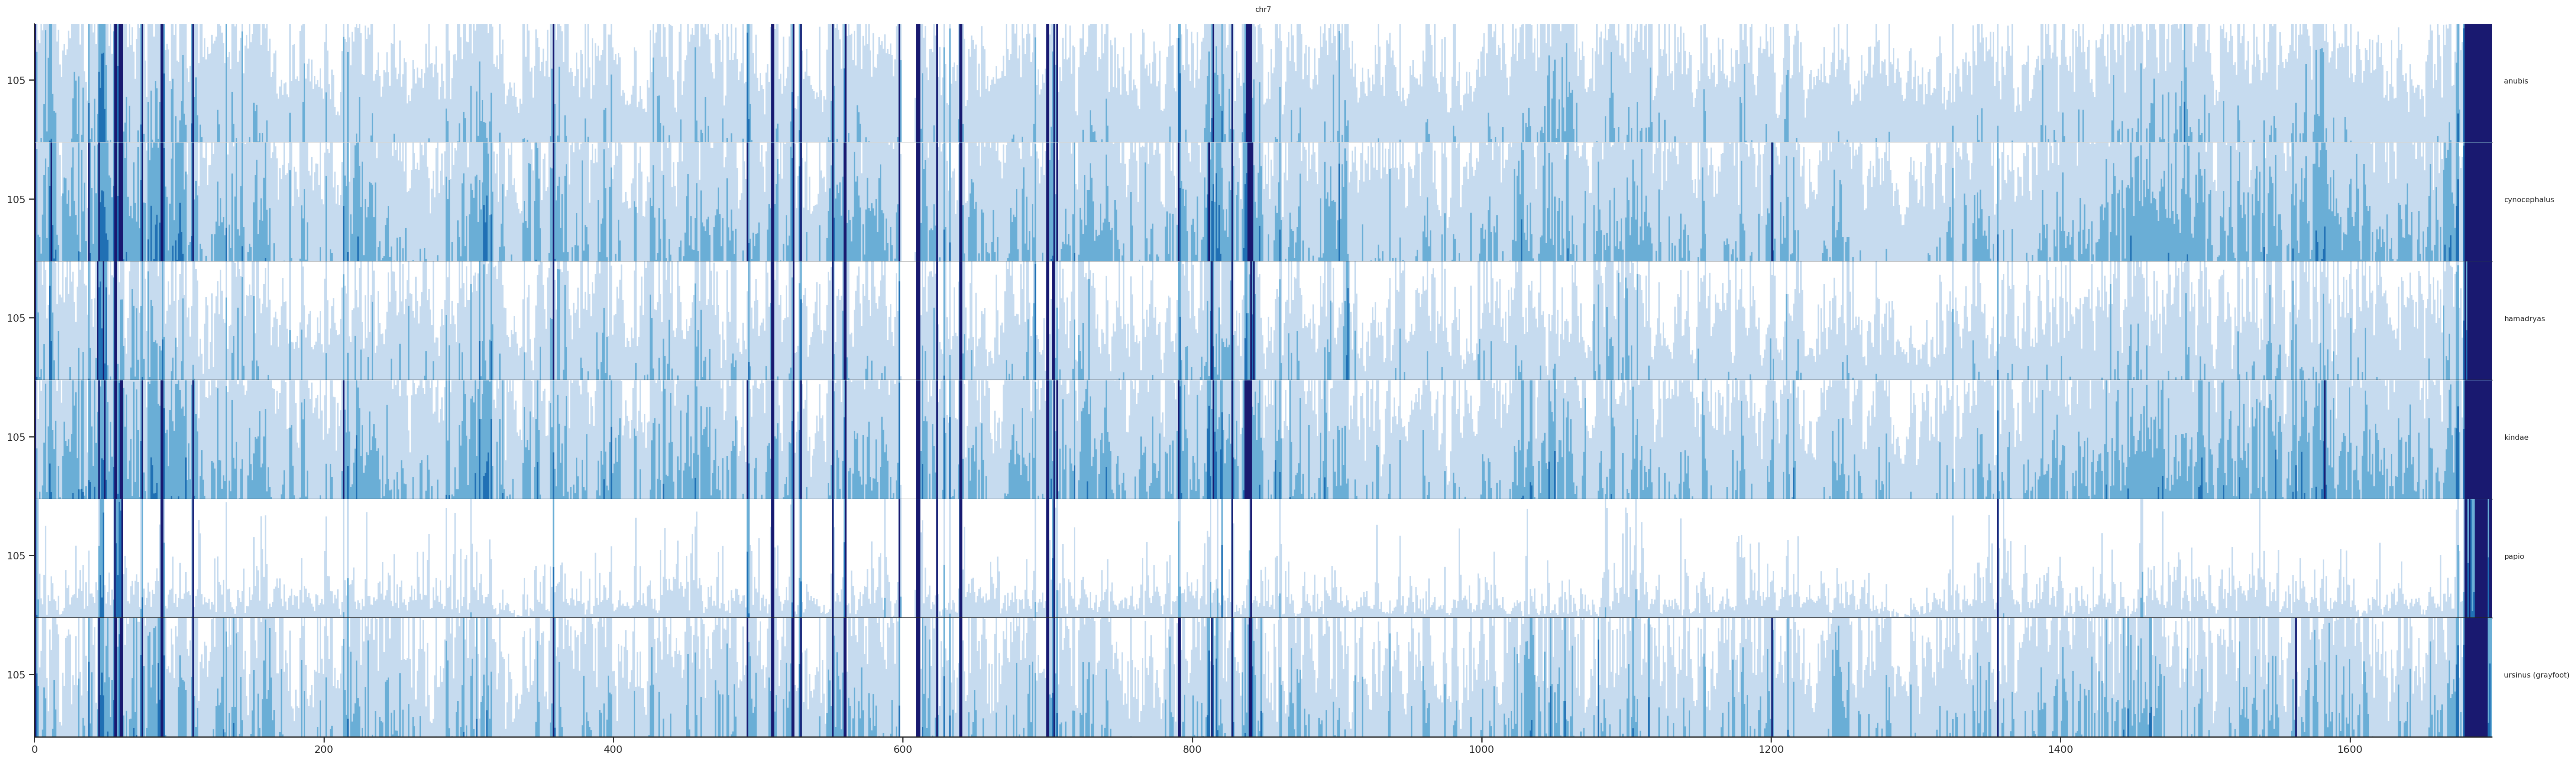

In [22]:
#Order of species in plot:
print(meta_data_samples.Species.unique())
fig = horizonplot(x_species,
                   'mean_het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 200)
fig = horizonplot(chr7_species,
                   'mean_het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 200)